In [1]:
import os
import cv2
import numpy as np
from skimage import feature
import random
from sklearn.preprocessing import LabelEncoder #to encode labels as integer
from xgboost import XGBClassifier #classifier
from sklearn.metrics import confusion_matrix, classification_report #to get the accuracy
from imutils import paths # to extract file path of each images
from imutils import build_montages #to visualize
from sklearn.metrics import accuracy_score #accuracy

C:\Users\Abdul Ghaffar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# extracting features from each image input
def imageFeatureExtraction(image):
    image_features = feature.hog(image, orientations=9,
    pixels_per_cell=(10, 10), cells_per_block=(2, 2),
    transform_sqrt=True, block_norm="L1")
    return image_features

In [3]:
def transformImage(path):
	imagePaths = list(paths.list_images(path))
	data = []
	labels = []

	for imagePath in imagePaths:
		label = imagePath.split(os.path.sep)[-2]
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		image = cv2.resize(image, (200, 200))
		image = cv2.threshold(image, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
			
		features = imageFeatureExtraction(image)
		data.append(features)
		labels.append(label)
  
	#converting to numpy array
	return (np.array(data), np.array(labels))

In [4]:
training_path = "D:/STUDIES/FINAL YEAR/FYP/IMPLEMENTATION/filtered/training"
testing_path = "D:/STUDIES/FINAL YEAR/FYP/IMPLEMENTATION/ParkinsonsDetection/SpiralDrawing/Dataset/spiral/testing"

In [5]:
(x_train, y_train) = transformImage(training_path)
(x_test, y_test) = transformImage(testing_path)

In [6]:
# Label Encoder
label_encode = LabelEncoder()
y_train = label_encode.fit_transform(y_train)
y_test = label_encode.transform(y_test)

In [7]:
# initialization of the model
model = XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
eval_set = [(x_train, y_train), (x_test, y_test)]
model.fit(x_train, y_train)

C:\Users\Abdul Ghaffar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:32:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.33,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
#Predicting from testing data
test_prediction = model.predict(x_test)
print(test_prediction)

[0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1]


In [9]:
#Calculating the accuracy from testing data
test_accuracy = accuracy_score(y_test, test_prediction)*100
print(test_accuracy)

73.33333333333333


In [10]:
#Predicting from training data
train_prediction = model.predict(x_train)
print(train_prediction)

[0 0 0 ... 1 1 1]


In [11]:
#Calculating the accuracy from training data
train_accuracy = accuracy_score(y_train, train_prediction)*100
print(train_accuracy)

100.0


In [15]:
# confusion matrix
cm = confusion_matrix(y_test, test_prediction)

In [16]:
# classification report which consists of performance rate
classificationReport = classification_report(y_test, test_prediction)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        15
           1       0.73      0.73      0.73        15

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30



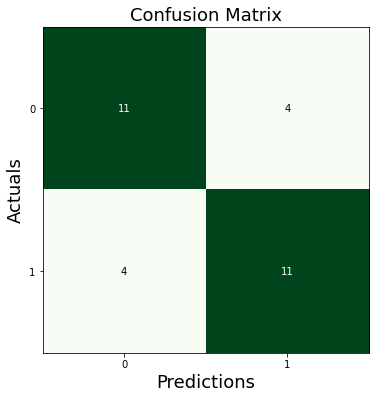

In [17]:
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [18]:
def test_prediction(model, testingPath):
    image = cv2.imread(testingPath)
    output = image.copy()
    output = cv2.resize(output, (128, 128))
    # pre-process the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255,
                          cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # extracting features
    features = imageFeatureExtraction(image)
    preds = model.predict([features])
    label = "Parkinsons" if preds[0] else "Healthy"
    return label


In [19]:
test_prediction(model, "testing_healthy.png")

'Healthy'

In [20]:
# Saving the model
import pickle

model_Filename = "SpiralModel.pkl"  

with open(model_Filename, 'wb') as file:  
    pickle.dump(model, file)